<a href="https://colab.research.google.com/github/AARNH/CL-with-DeepLabV3/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library dan modul yang diperlukan
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
from google.colab import drive
import zipfile
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.resnet import ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch.nn.functional as F
from torchvision.transforms.functional import resize
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.serialization import save
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.functional import interpolate
import random

torch.manual_seed(0)
random.seed(0)

drive.mount('/content/gdrive')
path_file_zip2 = '/content/gdrive/MyDrive/segmentation.zip'
echo_eks = '/content/echo_eks/'

with zipfile.ZipFile(path_file_zip2, 'r') as zip_ref:
    zip_ref.extractall(echo_eks)

print("File telah diekstrak di:", echo_eks)

Mounted at /content/gdrive
File telah diekstrak di: /content/echo_eks/


In [ ]:
# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transforms for images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Mean and std for single channel
])

# Transforms untuk mask
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class DeepLabV3Modified(nn.Module):
    def __init__(self, num_classes, model):
        super(DeepLabV3Modified, self).__init__()

        # Buat bagian lain dari model DeepLabV3 seperti biasa
        self.deepLabV3 = deeplabv3_resnet50(weights=None)

        # Ganti classifier head untuk jumlah kelas yang sesuai
        self.deepLabV3.classifier[4] = nn.Conv2d(256, num_classes, 1)
        self.deepLabV3.backbone.load_state_dict(model.state_dict(), strict=False)
    def forward(self, x):

        # Lakukan forward pass dengan model DeepLabV3
        deepLab_rep = self.deepLabV3(x)

        return deepLab_rep  # Return representasi hasil segmentasi

# Kelas dataset untuk dataset pelatihan
class CustomDataset(Dataset):
    def __init__(self, root_dir, image_transform=None, mask_transform=None, mode='train'):
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.mode = mode
        self.image_dir = os.path.join(root_dir, "imgs", self.mode)
        self.mask_dir = os.path.join(root_dir, "masks", self.mode)

        self.image_files = os.listdir(self.image_dir)
        self.mask_files = os.listdir(self.mask_dir)

        self.file_names = [os.path.splitext(img_name)[0] for img_name in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

def get_subset(dataset, percentage):
    total_size = len(dataset)
    subset_size = int(total_size * percentage)
    subset_indices = range(0, subset_size)
    subset = torch.utils.data.Subset(dataset, subset_indices)
    return subset

train_dataset = CustomDataset(root_dir='/content/echo_eks/segmentation', image_transform=image_transform, mask_transform=mask_transform, mode='train')
train_subset = get_subset(train_dataset, percentage=0.1)
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, drop_last=True)

test_dataset = CustomDataset(root_dir='/content/echo_eks/segmentation', image_transform=image_transform, mask_transform=mask_transform, mode='test')
test_subset = get_subset(test_dataset, percentage=0.1)
test_loader = DataLoader(test_subset, batch_size=4, shuffle=True, drop_last=True)

val_dataset = CustomDataset(root_dir='/content/echo_eks/segmentation', image_transform=image_transform, mask_transform=mask_transform, mode='val')
val_subset = get_subset(val_dataset, percentage=0.1)
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, drop_last=True)

# Load BYOL

In [ ]:
!pip install byol-pytorch
from byol_pytorch import BYOL

In [ ]:
BYOL = models.resnet50()
save_dir = '/content/gdrive/MyDrive'
model_fp = os.path.join(
    save_dir, "resnet50_state_dict_1.pth"
)
BYOL.load_state_dict(torch.load(model_fp, map_location=device))
BYOL = BYOL.to(device)

num_features = list(BYOL.children())[-1].in_features

# membuang lapisan fully connected layer
BYOL = nn.Sequential(*list(BYOL.children())[:-1])

# Load SIMCLR

In [ ]:
!pip install simclr
# !wget https://github.com/Spijkervet/SimCLR/releases/download/1.2/checkpoint_100.tar
from simclr import SimCLR
from simclr.modules import get_resnet

In [ ]:
# Load model SimCLR
encoder = models.resnet50(weights=None)
projection_dim = 64
n_features = encoder.fc.in_features
simclr_model = SimCLR(encoder, projection_dim, n_features)
save_dir = '/content/gdrive/MyDrive'
model_fp = os.path.join(
    save_dir, "checkpoint_95.tar"
)
simclr_model.load_state_dict(torch.load(model_fp, map_location=device))
simclr_model = simclr_model.to(device)
# # Inisialisasi model SimCLR yang telah dilatih
simclr_model.eval()
simclr_encoder = simclr_model.encoder

# DeeplabV3

In [ ]:
num_classes = 1 # Change this based on your number of classes
model = DeepLabV3Modified(num_classes,BYOL)
model.to(device)
# Mendefinisikan fungsi loss dan optimizer
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

# Jumlah total data individu (jumlah gambar dan masker) dalam train_loader
# num_batches = len(train_loader)
# print("Number of batches in train_loader:", num_batches)
# num_total_data = len(train_loader.dataset)
# print("Number of total data in train_loader:", num_total_data)
# val_num_batches = len(val_loader)
# print("Number of batches val_loader:", val_num_batches)
# num_total_data_val = len(val_loader.dataset)
# print("Number of total data in val_loader:", num_total_data_val)
# test_num_batches = len(test_loader)
# print("Number of batches test_loader:", test_num_batches)
# num_total_data_test = len(test_loader.dataset)
# # print("Number of total data in test_loader:", num_total_data_test)
for name, param in model.named_parameters():
    print(name)
# # Cetak bentuk bias dari layer DeepLabV3
# deepLabV3_bias_shape = model.deepLabV3.classifier[4]
# print("Bentuk bias dari DeepLabV3 layer4.2.bn3.bias:", deepLabV3_bias_shape)

# # Cetak bentuk bias dari simclr_encoder
# simclr_encoder_bias_shape = simclr_encoder.layer4[2].conv3.weight.shape
# print("Bentuk bias dari simclr_encoder layer4.2.bn3.bias:", simclr_encoder_bias_shape)

deepLabV3.backbone.conv1.weight
deepLabV3.backbone.bn1.weight
deepLabV3.backbone.bn1.bias
deepLabV3.backbone.layer1.0.conv1.weight
deepLabV3.backbone.layer1.0.bn1.weight
deepLabV3.backbone.layer1.0.bn1.bias
deepLabV3.backbone.layer1.0.conv2.weight
deepLabV3.backbone.layer1.0.bn2.weight
deepLabV3.backbone.layer1.0.bn2.bias
deepLabV3.backbone.layer1.0.conv3.weight
deepLabV3.backbone.layer1.0.bn3.weight
deepLabV3.backbone.layer1.0.bn3.bias
deepLabV3.backbone.layer1.0.downsample.0.weight
deepLabV3.backbone.layer1.0.downsample.1.weight
deepLabV3.backbone.layer1.0.downsample.1.bias
deepLabV3.backbone.layer1.1.conv1.weight
deepLabV3.backbone.layer1.1.bn1.weight
deepLabV3.backbone.layer1.1.bn1.bias
deepLabV3.backbone.layer1.1.conv2.weight
deepLabV3.backbone.layer1.1.bn2.weight
deepLabV3.backbone.layer1.1.bn2.bias
deepLabV3.backbone.layer1.1.conv3.weight
deepLabV3.backbone.layer1.1.bn3.weight
deepLabV3.backbone.layer1.1.bn3.bias
deepLabV3.backbone.layer1.2.conv1.weight
deepLabV3.backbone.layer1

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Inisialisasi variabel untuk early stopping
stopping = 5  # Jumlah epoch tanpa peningkatan sebelum early stopping
params_stop = 0  # Jumlah epoch tanpa peningkatan
min_epoch = 0  # Minimum jumlah epoch
max_epoch = 300  # Maksimum jumlah epoch
# Proses pelatihan
best_val_dsc = 0.0
train_losses = []
# Proses pelatihan
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        try:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)['out']

            # Mengaktifkan keluaran dengan sigmoid
            predicted_masks = torch.sigmoid(outputs)
            masks = masks[:, :1, :, :].squeeze(1)
            predicted_masks = predicted_masks[:, :1, :, :].squeeze(1)
            # Menghitung loss pada setiap piksel masker
            loss = criterion(predicted_masks, masks)
            loss.backward()
            optimizer.step()

            # print(f"nilai loss: {loss:.4f}")
            running_loss += loss.item() * images.size(0)
        except Exception as e:
            print("Error occurred:", e)
    train_losses.append(running_loss / len(train_loader))
    # Evaluasi pada data validasi setiap epoch
    model.eval()
    total_dice_score = 0.0
    total_intersection = 0
    total_union = 0
    # threshold = 0.6

    with torch.no_grad():
      for images, masks in val_loader:
          images, masks = images.to(device), masks.to(device)

          # Forward pass
          outputs = model(images)['out']
          outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

          # Ubah output menjadi 1 saluran
          # outputs = outputs[:, 1, :, :].unsqueeze(1)

          # Ubah mask menjadi 1 saluran
          masks = masks[:, 1, :, :].unsqueeze(1)
          # Convert outputs to binary masks based on the threshold
          predicted_masks = torch.sigmoid(outputs)

          # Calculate Dice Similarity Coefficient (DSC)
          intersection = torch.sum(predicted_masks * masks)
          union = torch.sum(predicted_masks) + torch.sum(masks)
          dsc_batch = (2.0 * intersection + 1e-6) / (union + 1e-6)
          total_dice_score += dsc_batch.item()

          # Calculate IoU (Intersection over Union)
          total_intersection += intersection.item()
          union_iou = torch.sum(predicted_masks) + torch.sum(masks)-intersection
          total_union += union_iou.item()

    # Calculate average metrics over the entire validation set
    average_dice_score = total_dice_score / len(val_loader)
    iou = total_intersection / total_union

    # Print the results for each epoch
    print(f"Epoch: {epoch + 1}/{max_epoch}",
          f"Validation Dice Score: {average_dice_score:.4f}",
          f"Validation IoU: {iou:.4f}")


    if epoch >= min_epoch:
      if average_dice_score > best_val_dsc:
          best_val_dsc = average_dice_score
          params_stop = 0
      else:
          params_stop += 1

    # Early stopping
    if params_stop > stopping:
        print(f"Early stopping at epoch {epoch}. Best Validation DSC: {best_val_dsc:.4f}")
        break

Epoch: 1/300 Validation Dice Score: 0.8173 Validation IoU: 0.6946
Epoch: 2/300 Validation Dice Score: 0.8236 Validation IoU: 0.7012
Epoch: 3/300 Validation Dice Score: 0.8398 Validation IoU: 0.7261
Epoch: 4/300 Validation Dice Score: 0.8395 Validation IoU: 0.7246
Epoch: 5/300 Validation Dice Score: 0.8330 Validation IoU: 0.7169
Epoch: 6/300 Validation Dice Score: 0.8425 Validation IoU: 0.7298
Epoch: 7/300 Validation Dice Score: 0.8377 Validation IoU: 0.7238
Epoch: 8/300 Validation Dice Score: 0.8318 Validation IoU: 0.7124
Epoch: 9/300 Validation Dice Score: 0.8396 Validation IoU: 0.7256
Epoch: 10/300 Validation Dice Score: 0.8439 Validation IoU: 0.7326
Epoch: 11/300 Validation Dice Score: 0.8396 Validation IoU: 0.7251
Epoch: 12/300 Validation Dice Score: 0.8415 Validation IoU: 0.7268
Epoch: 13/300 Validation Dice Score: 0.8475 Validation IoU: 0.7374
Epoch: 14/300 Validation Dice Score: 0.8436 Validation IoU: 0.7310
Epoch: 15/300 Validation Dice Score: 0.8433 Validation IoU: 0.7310
Epoc

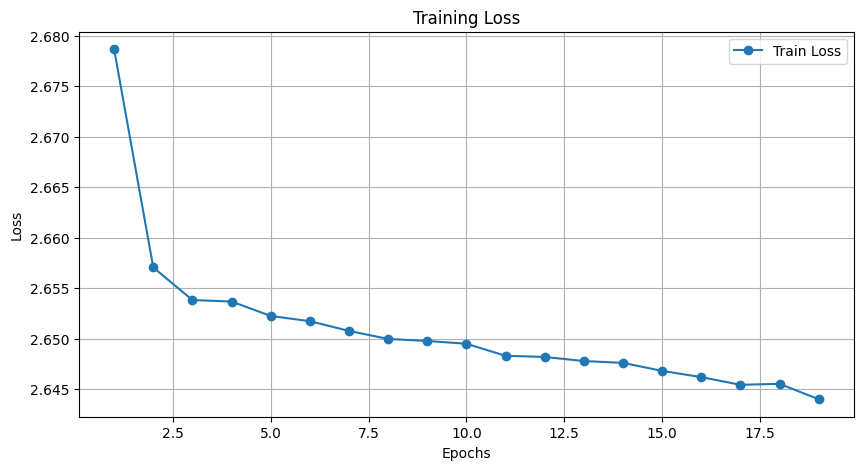

In [ ]:
# Menggambar grafik Loss pelatihan
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Jumlah nama file yang ingin dicetak
num_files_to_print = 10

# Loop melalui file_loader untuk mencetak nama file
for idx, file_name in enumerate(val_loader.dataset.dataset.file_names):
    if idx < num_files_to_print:
        print(file_name)
    else:
        break  # Berhenti setelah mencetak 10 nama file


0X1D8D28801D701B6_19_0
0X61970056C330866C_116_0
0X69635DF0D0C9AE26_46_0
0X3B9FBD87EE113D62_144_0
0X15E8BE2AE8C05C88_72_1
0X216E6AFF3D3589CD_58_0
0X47B3F561C23EFC83_74_0
0X6FCB1BA18A58D7F2_51_1
0X28EDDD27E7D737BB_104_0
0X63CC93D7D9696690_113_0


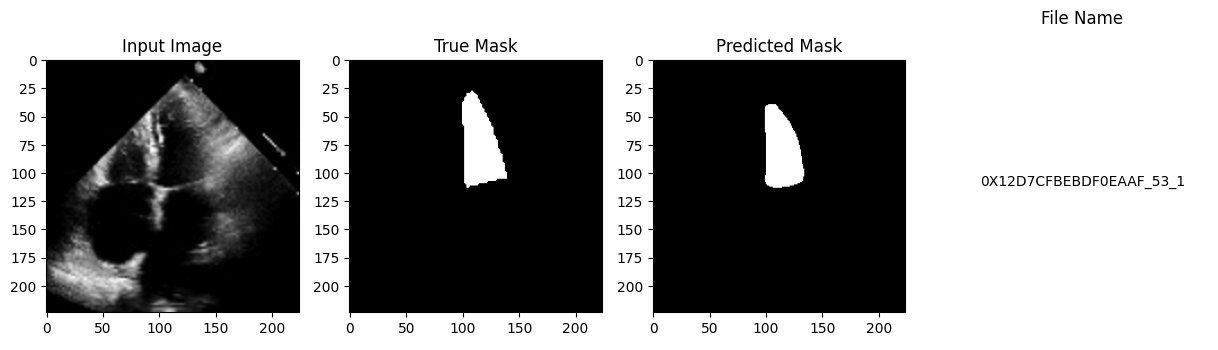

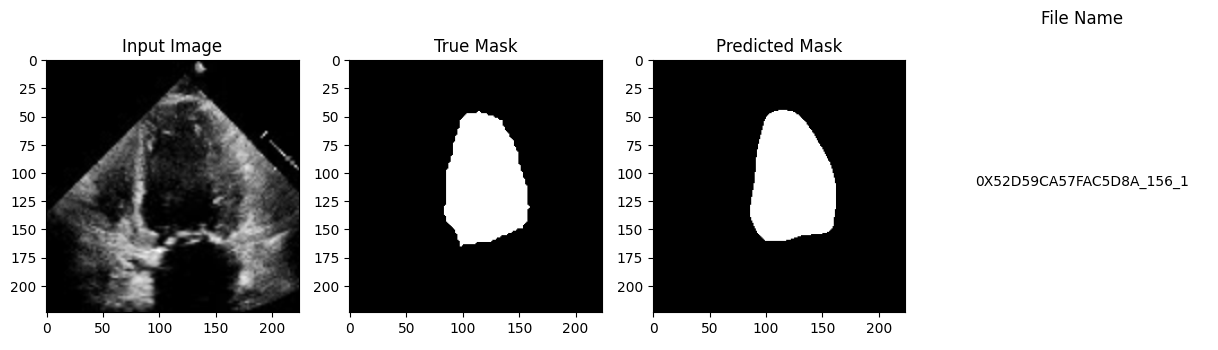

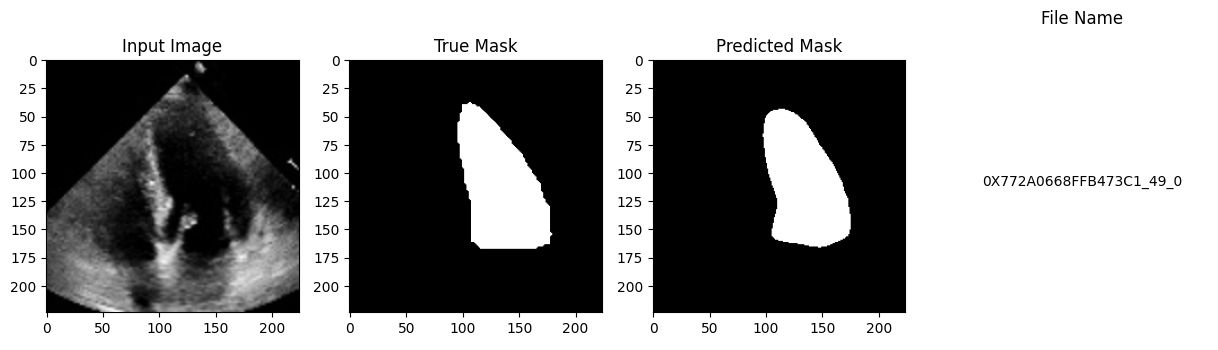

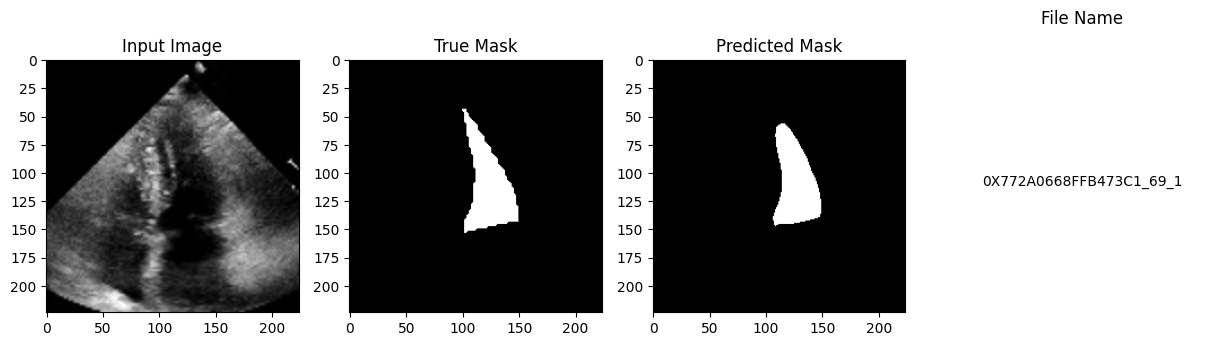

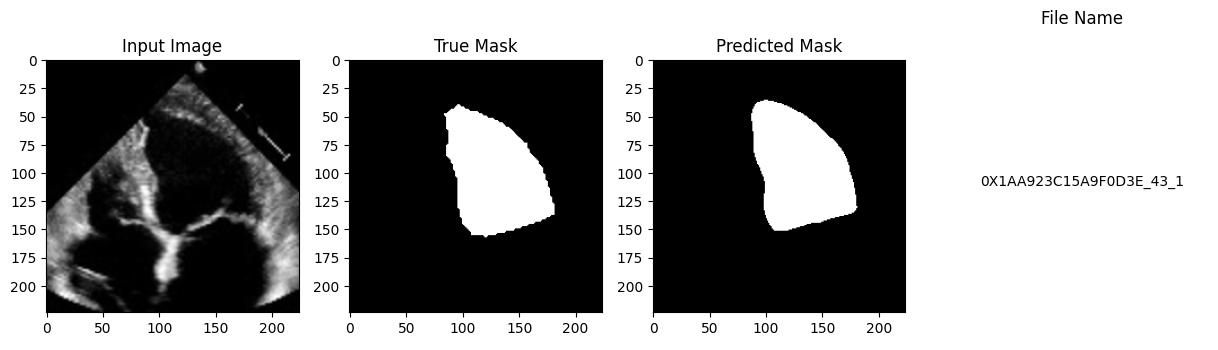

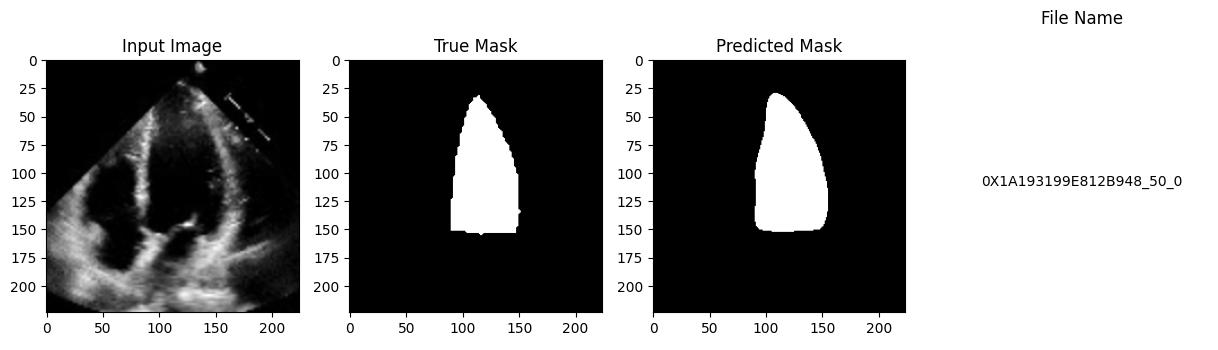

In [ ]:
import os

# List nama file yang ingin Anda visualisasikan
file_names = [
    "0X12D7CFBEBDF0EAAF_53_1",
    "0X52D59CA57FAC5D8A_156_1",
    "0X772A0668FFB473C1_49_0",
    "0X772A0668FFB473C1_69_1",
    "0X1AA923C15A9F0D3E_43_1",
    "0X1A193199E812B948_50_0",
]

# Loop melalui setiap nama file
for file_name in file_names:
    idx = val_loader.dataset.dataset.file_names.index(file_name)  # Cari indeks dari nama file ini dalam dataset

    val_inputs, val_masks = val_loader.dataset.dataset[idx]  # Gunakan val_loader.dataset untuk akses data validasi
    val_inputs = val_inputs.unsqueeze(0).to(device)
    val_masks = val_masks.unsqueeze(0).to(device)

    val_outputs = model(val_inputs)['out']

    # Menyesuaikan ukuran tensor output model agar sesuai dengan ukuran masker
    val_outputs = F.interpolate(val_outputs, size=val_masks.shape[2:], mode='bilinear', align_corners=False)
    # Apply threshold to convert predicted output to binary mask
    threshold = 0.5
    predicted_binary = torch.where(val_outputs[:, 0, :, :] > threshold, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))

    # Ubah masker menjadi tensor biner (0 atau 1)
    val_masks_binary = (val_masks > threshold).float()

    # Simpan hanya bagian predicted mask
    save_directory = '/content/gdrive/MyDrive/'
    save_path = os.path.join(save_directory, f"predicted_mask_Resnet50{file_name}.png")
    plt.imsave(save_path, predicted_binary[0].cpu().numpy(), cmap='gray')

    # Tampilkan gambar bersama dengan true mask, predict mask, dan nama file
    val_input_sample = val_inputs.cpu().numpy()
    true_mask_sample = val_masks_binary.cpu().numpy()

    plt.figure(figsize=(15, 4))

    # Tampilkan gambar input (misalnya gambar dari channel pertama)
    plt.subplot(1, 4, 1)
    plt.imshow(val_input_sample[0, 0], cmap='gray')
    plt.title('Input Image')

    # Tampilkan true mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask_sample[0, 0], cmap='gray')
    plt.title('True Mask')

    # Tampilkan predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_binary[0].cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    # Tampilkan nama file
    plt.subplot(1, 4, 4)
    plt.text(0.5, 0.5, file_name, fontsize=10, ha='center')
    plt.axis('off')
    plt.title('File Name')

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Indeks contoh gambar yang ingin Anda gunakan
sample_image_idx = val_loader.dataset.dataset.file_names.index("0X12D7CFBEBDF0EAAF_53_1")

# Definisikan lapisan yang ingin Anda visualisasikan
target_layers = [
    "deepLabV3.backbone.conv1",
    "deepLabV3.classifier.0.convs.0.0",
    "deepLabV3.classifier.0.convs.4.2",
    "deepLabV3.classifier.0.project.1",
    "deepLabV3.classifier.4"
]

# Ukuran subplot
num_rows = len(target_layers)
num_cols = 1  # Sesuaikan dengan jumlah feature maps yang ingin Anda tampilkan

# Visualisasikan perubahan gambar saat melewati lapisan-lapisan
for layer_name in target_layers:
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    # Mendapatkan modul berdasarkan nama lapisan
    module = model
    layer_names = layer_name.split('.')
    for name in layer_names:
        if isinstance(module, torch.nn.Module):
            module = getattr(module, name)
        else:
            module = module[name]

    # Mendaftarkan hook pada modul yang sesuai
    module.register_forward_hook(hook_fn)

    with torch.no_grad():
        sample_image = val_loader.dataset.dataset[sample_image_idx][0].unsqueeze(0).to(device)
        model(sample_image)

    feature_maps = activations[0]

    plt.figure(figsize=(20, 5))
    plt.suptitle(layer_name, fontsize=16)

    for i in range(min(num_cols, feature_maps.size(1))):
        plt.subplot(1, num_cols, i + 1)
        plt.imshow(feature_maps[0, i].cpu(), cmap='viridis')
        plt.axis('off')

    plt.show()


ValueError: ignored

In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
total_dice_score = 0.0
total_intersection = 0
total_union = 0
threshold = 0.4
with torch.no_grad():  # Disable gradient calculation during testing
    for images, masks in test_loader:
      try:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

        # Ubah output menjadi 1 saluran
        outputs = outputs[:, 1, :, :].unsqueeze(1)

        # Ubah mask menjadi 1 saluran
        masks = masks[:, 1, :, :].unsqueeze(1)
        loss = criterion(outputs, masks)

        test_loss += loss.item()

        # Convert outputs to binary masks based on the threshold
        predicted_masks = torch.sigmoid(outputs) > threshold
        predicted_masks = predicted_masks.float()

        # Calculate Dice Similarity Coefficient (DSC)
        intersection = torch.sum(predicted_masks * masks)
        union = torch.sum(predicted_masks) + torch.sum(masks)
        dsc_batch = (2.0 * intersection + 1e-6) / (union + 1e-6)
        total_dice_score += dsc_batch.item()

        # Calculate IoU (Intersection over Union)
        total_intersection += intersection.item()
        union_iou = torch.sum(predicted_masks) + torch.sum(masks)-intersection
        total_union += union_iou.item()
      except Exception as e:
        print("Error occurred:", e)

average_loss = test_loss / len(test_loader)
average_dice_score = total_dice_score / len(test_loader)
iou = total_intersection / total_union
print(f"Test Loss: {average_loss:.4f}",
      f"Test Dice Score: {average_dice_score:.4f}",
      f"Test IoU: {iou:.4f}")

KeyboardInterrupt: ignored

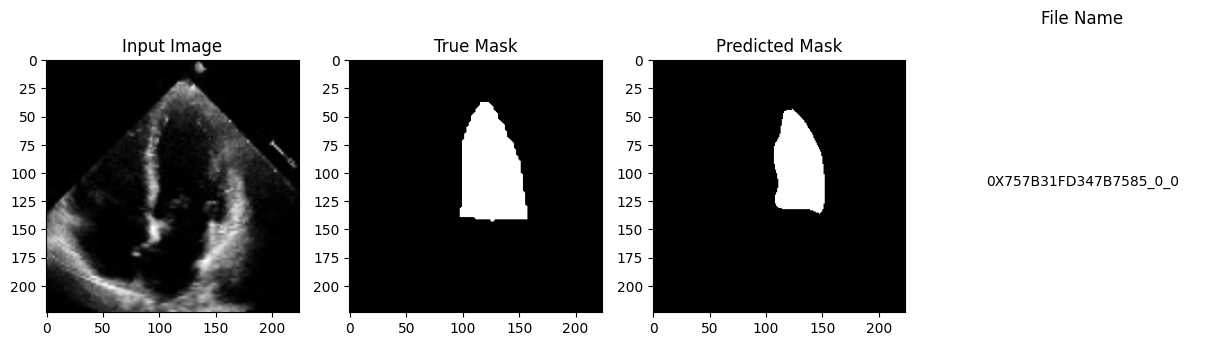

<Figure size 640x480 with 0 Axes>

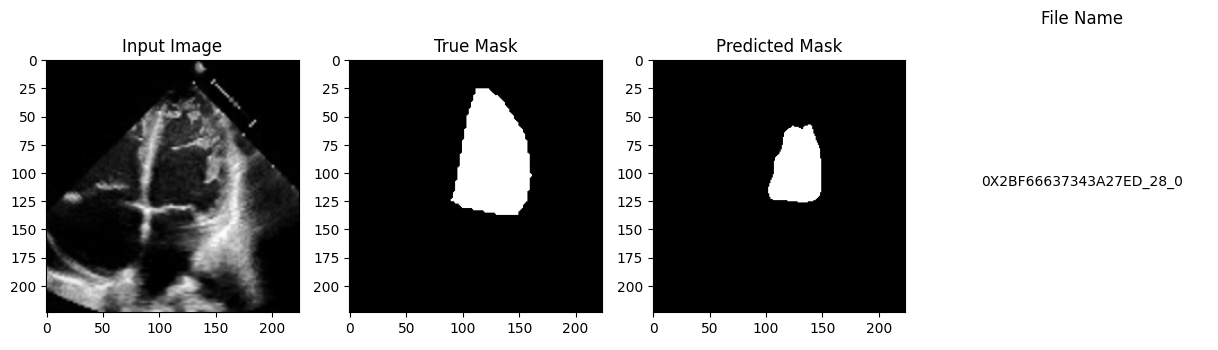

<Figure size 640x480 with 0 Axes>

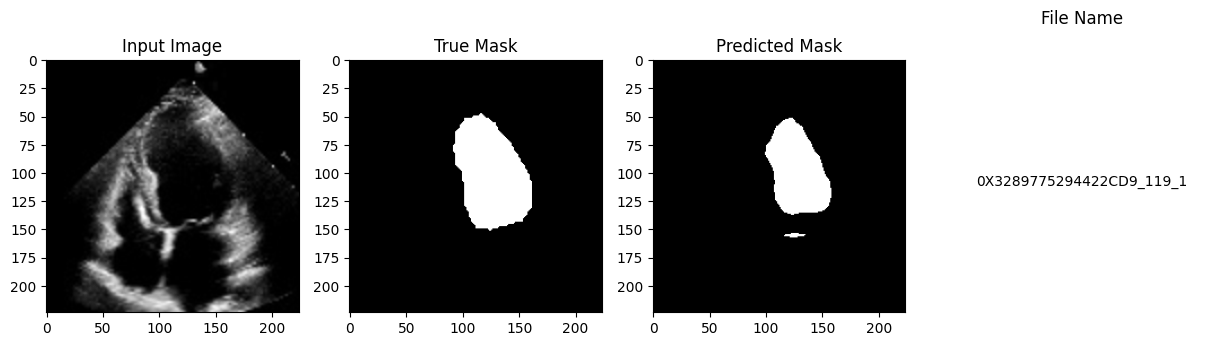

<Figure size 640x480 with 0 Axes>

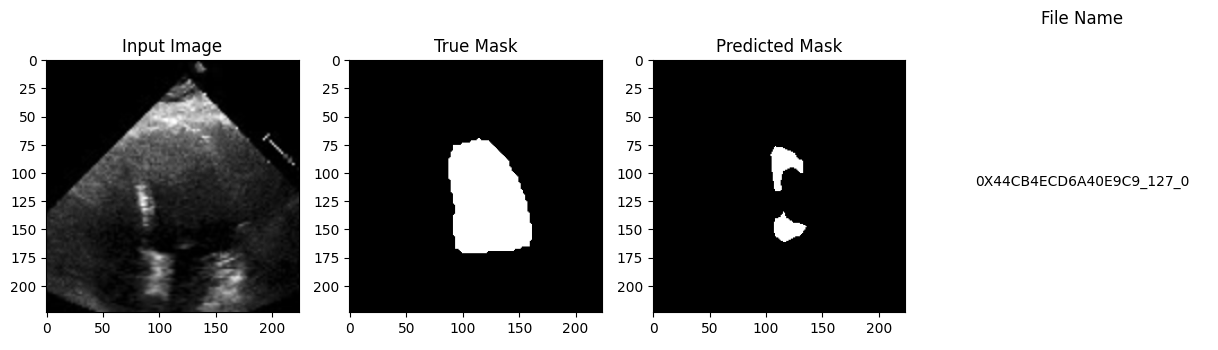

<Figure size 640x480 with 0 Axes>

In [ ]:
num_examples_to_show = 4

# Loop melalui contoh dataset secara berurutan
for idx in range(num_examples_to_show):
    test_inputs, test_masks = test_loader.dataset.dataset[idx]
    test_inputs = test_inputs.unsqueeze(0).to(device)
    test_masks = test_masks.unsqueeze(0).to(device)

    test_outputs = model(test_inputs)['out']

    # Menyesuaikan ukuran tensor output model agar sesuai dengan ukuran masker
    test_outputs = F.interpolate(test_outputs, size=test_masks.shape[2:], mode='bilinear', align_corners=False)
    # Apply threshold to convert predicted output to binary mask
    threshold = 0.55
    predicted_binary = torch.where(test_outputs[:, 1, :, :] > threshold, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))

    # Ubah masker menjadi tensor biner (0 atau 1)
    test_masks_binary = (test_masks > threshold).float()

    # Dapatkan nama file untuk contoh saat ini
    file_name = test_loader.dataset.dataset.file_names[idx]

    # Tampilkan gambar bersama dengan true mask, predict mask, dan nama file
    test_input_sample = test_inputs.cpu().numpy()
    true_mask_sample = test_masks_binary.cpu().numpy()

    plt.figure(figsize=(15, 4))

    # Tampilkan gambar input (misalnya gambar dari channel pertama)
    plt.subplot(1, 4, 1)
    plt.imshow(test_input_sample[0, 0], cmap='gray')
    plt.title('Input Image')

    # Tampilkan true mask
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask_sample[0, 0], cmap='gray')
    plt.title('True Mask')

    # Tampilkan predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(predicted_binary[0].cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    # Tampilkan nama file
    plt.subplot(1, 4, 4)
    plt.text(0.5, 0.5, file_name, fontsize=10, ha='center')
    plt.axis('off')
    plt.title('File Name')

    plt.show()
    plt.savefig(f"example_{file_name}.png")